In [1]:
%matplotlib inline



Head model and forward computation
==================================

The aim of this tutorial is to be a getting started for forward
computation.

For more extensive details and presentation of the general
concepts for forward modeling. See `ch_forward`.




In [7]:
import mne
from mne.datasets import sample
data_path = sample.data_path()

# the raw file containing the channel location + types
raw_fname = data_path + '/MEG/sample/sample_audvis_raw.fif'
# The paths to Freesurfer reconstructions
subjects_dir = data_path + '/subjects'
subject = 'sample'

Computing the forward operator
------------------------------

To compute a forward operator we need:

   - a ``-trans.fif`` file that contains the coregistration info.
   - a source space
   - the BEM surfaces



Compute and visualize BEM surfaces
----------------------------------

The BEM surfaces are the triangulations of the interfaces between different
tissues needed for forward computation. These surfaces are for example
the inner skull surface, the outer skull surface and the outer skill
surface.

Computing the BEM surfaces requires FreeSurfer and makes use of either of
the two following command line tools:

  - `gen_mne_watershed_bem`
  - `gen_mne_flash_bem`

Here we'll assume it's already computed. It takes a few minutes per subject.

For EEG we use 3 layers (inner skull, outer skull, and skin) while for
MEG 1 layer (inner skull) is enough.

Let's look at these surfaces. The function :func:`mne.viz.plot_bem`
assumes that you have the the *bem* folder of your subject FreeSurfer
reconstruction the necessary files.



Using surface: /Users/DanielLongo/mne_data/MNE-sample-data/subjects/sample/bem/inner_skull.surf
Using surface: /Users/DanielLongo/mne_data/MNE-sample-data/subjects/sample/bem/outer_skull.surf
Using surface: /Users/DanielLongo/mne_data/MNE-sample-data/subjects/sample/bem/outer_skin.surf


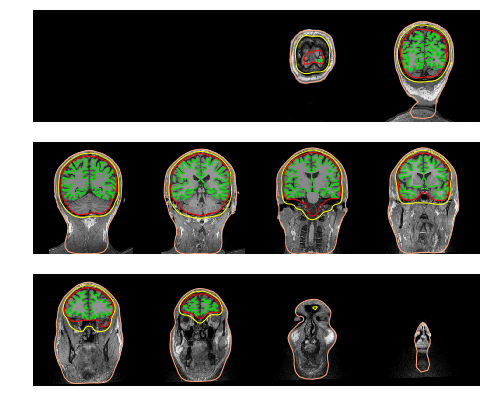

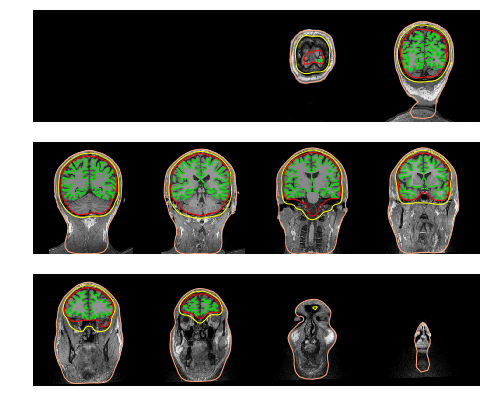

In [3]:
mne.viz.plot_bem(subject=subject, subjects_dir=subjects_dir,
                 brain_surfaces='white', orientation='coronal')

Visualization the coregistration
--------------------------------

The coregistration is operation that allows to position the head and the
sensors in a common coordinate system. In the MNE software the transformation
to align the head and the sensors in stored in a so-called **trans file**.
It is a FIF file that ends with -trans.fif. It can be obtained with
mne_analyze (Unix tools), mne.gui.coregistration (in Python) or mrilab
if you're using a Neuromag system.

For the Python version see :func:`mne.gui.coregistration`

Here we assume the coregistration is done, so we just visually check the
alignment with the following code.



In [8]:
# The transformation file obtained by coregistration
trans = data_path + '/MEG/sample/sample_audvis_raw-trans.fif'

info = mne.io.read_info(raw_fname)
# Here we look at the dense head, which isn't used for BEM computations but
# is useful for coregistration.
mne.viz.plot_alignment(info, trans, subject=subject, dig=True,
                       meg=['helmet', 'sensors'], subjects_dir=subjects_dir,
                       surfaces='head-dense')

    Read a total of 3 projection items:
        PCA-v1 (1 x 102)  idle
        PCA-v2 (1 x 102)  idle
        PCA-v3 (1 x 102)  idle


RuntimeError: No traitsui.toolkits plugin found for toolkit null

Compute Source Space
--------------------

The source space defines the position of the candidate source locations.
The following code compute such a cortical source space with
an OCT-6 resolution.

See `setting_up_source_space` for details on source space definition
and spacing parameter.



In [9]:
src = mne.setup_source_space(subject, spacing='oct6',
                             subjects_dir=subjects_dir, add_dist=False)
print(src)

Setting up the source space with the following parameters:

SUBJECTS_DIR = /Users/DanielLongo/mne_data/MNE-sample-data/subjects
Subject      = sample
Surface      = white
Octahedron subdivision grade 6

>>> 1. Creating the source space...

Doing the octahedral vertex picking...
Loading /Users/DanielLongo/mne_data/MNE-sample-data/subjects/sample/surf/lh.white...
Mapping lh sample -> oct (6) ...
    Triangle neighbors and vertex normals...
Loading geometry from /Users/DanielLongo/mne_data/MNE-sample-data/subjects/sample/surf/lh.sphere...
Setting up the triangulation for the decimated surface...
loaded lh.white 4098/155407 selected to source space (oct = 6)

Loading /Users/DanielLongo/mne_data/MNE-sample-data/subjects/sample/surf/rh.white...
Mapping rh sample -> oct (6) ...
    Triangle neighbors and vertex normals...
Loading geometry from /Users/DanielLongo/mne_data/MNE-sample-data/subjects/sample/surf/rh.sphere...
Setting up the triangulation for the decimated surface...
loaded rh.white

``src`` contains two parts, one for the left hemisphere (4098 locations) and
one for the right hemisphere (4098 locations). Sources can be visualized on
top of the BEM surfaces.



Using surface: /Users/DanielLongo/mne_data/MNE-sample-data/subjects/sample/bem/inner_skull.surf
Using surface: /Users/DanielLongo/mne_data/MNE-sample-data/subjects/sample/bem/outer_skull.surf
Using surface: /Users/DanielLongo/mne_data/MNE-sample-data/subjects/sample/bem/outer_skin.surf


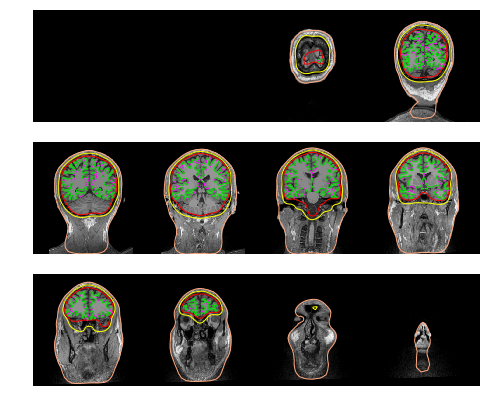

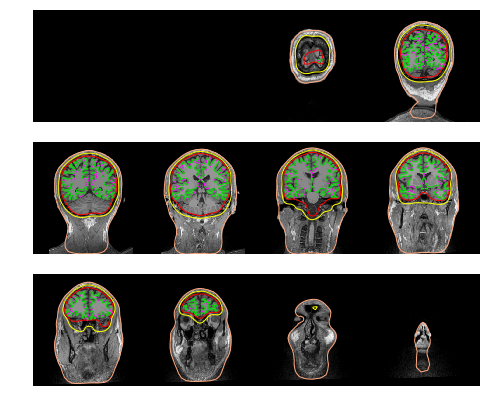

In [10]:
mne.viz.plot_bem(subject=subject, subjects_dir=subjects_dir,
                 brain_surfaces='white', src=src, orientation='coronal')

However, only sources that lie in the plotted MRI slices are shown.
Let's write a few lines of mayavi to see all sources.



In [11]:
import numpy as np  # noqa
from mayavi import mlab  # noqa
from surfer import Brain  # noqa

brain = Brain('sample', 'lh', 'inflated', subjects_dir=subjects_dir)
surf = brain.geo['lh']

vertidx = np.where(src[0]['inuse'])[0]

mlab.points3d(surf.x[vertidx], surf.y[vertidx],
              surf.z[vertidx], color=(1, 1, 0), scale_factor=1.5)

RuntimeError: No traitsui.toolkits plugin found for toolkit null

Compute forward solution
------------------------

We can now compute the forward solution.
To reduce computation we'll just compute a single layer BEM (just inner
skull) that can then be used for MEG (not EEG).

We specify if we want a one-layer or a three-layer BEM using the
conductivity parameter.

The BEM solution requires a BEM model which describes the geometry
of the head the conductivities of the different tissues.



In [12]:
conductivity = (0.3,)  # for single layer
# conductivity = (0.3, 0.006, 0.3)  # for three layers
model = mne.make_bem_model(subject='sample', ico=4,
                           conductivity=conductivity,
                           subjects_dir=subjects_dir)
bem = mne.make_bem_solution(model)

Creating the BEM geometry...
Going from 4th to 4th subdivision of an icosahedron (n_tri: 5120 -> 5120)
inner skull CM is   0.67 -10.01  44.26 mm
Surfaces passed the basic topology checks.
Complete.

Approximation method : Linear collocation

Homogeneous model surface loaded.
Computing the linear collocation solution...
    Matrix coefficients...
        inner_skull (2562) -> inner_skull (2562) ...
    Inverting the coefficient matrix...
Solution ready.
BEM geometry computations complete.


Note that the BEM does not involve any use of the trans file. The BEM
only depends on the head geometry and conductivities.
It is therefore independent from the MEG data and the head position.

Let's now compute the forward operator, commonly referred to as the
gain or leadfield matrix.

See :func:`mne.make_forward_solution` for details on parameters meaning.



In [ ]:
fwd = mne.make_forward_solution(raw_fname, trans=trans, src=src, bem=bem,
                                meg=True, eeg=False, mindist=5.0, n_jobs=2)
print(fwd)

Source space          : <SourceSpaces: [<surface (lh), n_vertices=155407, n_used=4098, coordinate_frame=MRI (surface RAS)>, <surface (rh), n_vertices=156866, n_used=4098, coordinate_frame=MRI (surface RAS)>]>
MRI -> head transform : /Users/DanielLongo/mne_data/MNE-sample-data/MEG/sample/sample_audvis_raw-trans.fif
Measurement data      : sample_audvis_raw.fif
Conductor model   : instance of ConductorModel
Accurate field computations
Do computations in head coordinates
Free source orientations

Read 2 source spaces a total of 8196 active source locations

Coordinate transformation: MRI (surface RAS) -> head
     0.999310  0.009985 -0.035787      -3.17 mm
     0.012759  0.812405  0.582954       6.86 mm
     0.034894 -0.583008  0.811716      28.88 mm
     0.000000  0.000000  0.000000       1.00

Read 306 MEG channels from info
84 coil definitions read
Coordinate transformation: MEG device -> head
     0.991420 -0.039936 -0.124467      -6.13 mm
     0.060661  0.984012  0.167456       0.06 

[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    3.1s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    3.1s finished


1 source space point omitted because it is outside the inner skull surface.
331 source space point omitted because of the    5.0-mm distance limit.
Thank you for waiting.

Setting up compensation data...
    No compensation set. Nothing more to do.

Composing the field computation matrix...


[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    3.1s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    3.1s finished


Computing MEG at 7498 source locations (free orientations)...


[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    3.1s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    3.1s finished


We can explore the content of fwd to access the numpy array that contains
the gain matrix.



In [ ]:
leadfield = fwd['sol']['data']
print("Leadfield size : %d sensors x %d dipoles" % leadfield.shape)

To extract the numpy array containing the forward operator corresponding to
the source space `fwd['src']` with cortical orientation constraint
we can use the following:



In [ ]:
fwd_fixed = mne.convert_forward_solution(fwd, surf_ori=True, force_fixed=True,
                                         use_cps=True)
leadfield = fwd_fixed['sol']['data']
print("Leadfield size : %d sensors x %d dipoles" % leadfield.shape)

This is equivalent to the following code that explicitly applies the
forward operator to a source estimate composed of the identity operator:



In [ ]:
n_dipoles = leadfield.shape[1]
vertices = [src_hemi['vertno'] for src_hemi in fwd_fixed['src']]
stc = mne.SourceEstimate(1e-9 * np.eye(n_dipoles), vertices, tmin=0., tstep=1)
leadfield = mne.apply_forward(fwd_fixed, stc, info).data / 1e-9

To save to disk a forward solution you can use
:func:`mne.write_forward_solution` and to read it back from disk
:func:`mne.read_forward_solution`. Don't forget that FIF files containing
forward solution should end with *-fwd.fif*.

To get a fixed-orientation forward solution, use
:func:`mne.convert_forward_solution` to convert the free-orientation
solution to (surface-oriented) fixed orientation.



Exercise
--------

By looking at
`sphx_glr_auto_examples_forward_plot_forward_sensitivity_maps.py`
plot the sensitivity maps for EEG and compare it with the MEG, can you
justify the claims that:

  - MEG is not sensitive to radial sources
  - EEG is more sensitive to deep sources

How will the MEG sensitivity maps and histograms change if you use a free
instead if a fixed/surface oriented orientation?

Try this changing the mode parameter in :func:`mne.sensitivity_map`
accordingly. Why don't we see any dipoles on the gyri?

